In [ ]:
# gamesvenv
from openai import OpenAI 
import json
import pickle
import json
import re
 
 
import numpy as np
#import pandas as pd

path = "config.json"

with open(path, "r") as f:
    config = json.load(f)

openai_api_key = config["OPENAI_API_KEY"] 

Set up personas

In [2]:
def RandomAdult():

       male_names = ["Liam", "Noah", "Oliver", "Elijah", "William", "James", "Benjamin", "Lucas", "Henry", "Alexander"]
       male_names_p = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
       female_names = ["Olivia", "Emma", "Ava", "Charlotte", "Sophia", "Amelia", "Isabella", "Mia", "Evelyn", "Harper"]
       female_names_p = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

       sex = ["mother", "father"]
       sex_p = [0.5, 0.5] 

       children = ["a son", "a daughter", "two kids", "three kids"]
       children_p = [0.25, 0.25, 0.25, 0.25]

       age = ["30", "35", "40", "45"]
       age_p = [0.25, 0.25, 0.25, 0.25] 
       party = ["Left of Center", "Right of Center", "Centrist" ]
       party_p = [0.3, 0.3, 0.4]
       region = ["Northeast", "Midwest", "South", "West"]
       region_p = [0.25, 0.25, 0.25, 0.25]  
       major = ["policical scientist", "engineer", "educator", "computer scientist", "economist", "plumer", "home builder", "car salesman", "manager at a large companay", "mechanic"]
       major_p = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] 
       day = ["It's been a pretty hectic day and you are in a bit of a rush.", "You are just out doing some shopping.", 
              "You are on your way back from coffee with a friend.", "You are on your way home from work."]
       day_p = [0.25, 0.25, 0.25, 0.25] 

       mysex = np.random.choice(sex, p=sex_p)
       myname = f"{np.random.choice(male_names, p=male_names_p)}" if mysex == 'father' else f"{np.random.choice(female_names, p=female_names_p)}" 
       myage = np.random.choice(age, p=age_p)
       mychildren = np.random.choice(children, p=children_p)
       myparty = np.random.choice(party, p=party_p)
       myregion = np.random.choice(region, p=region_p)   
       mymajor = np.random.choice(major, p=major_p) 
       myday = np.random.choice(day, p=day_p)

       mytype = {"mysex": mysex, "myname": myname, "myage": myage, "mychildren": mychildren, "myparty": myparty, "myregion": myregion, "mymajor": mymajor, "myday": myday}

       system = f"You are role playing. You are {myname},  a {myage} year old {mysex} of {mychildren} and you work as a {mymajor}. You only reply as {myname}. \
You are from {myregion} and identify {myparty} politically. \
{myday}"
       
       return system, mytype


Set up Functions and system prompt

In [3]:
dictatorFn = [{
    "type": "function",
    "function": {
        "name": "split_function",
        "description": "How much of the $100 to keep for yourself, the other player gets the rest.",
        "parameters": {
            "type": "object",
            "properties": {
                "choice": {
                    "type": "number",
                    "description": "How much of the $100 to keep for yourself." 
                }        
            },
            "required": ["choice"],
            "additionalProperties": False
        },
        "strict": True
    }
}]

SysAdd = "You are about to play an economic game with real money. You will be given $100 and you must decide how to spit it \
between you and another player. However, if the other player rejects your offer, you both get zero. You have a function \
'split_function' to reply with using the 'choice' argument to give your answer. Only use your function 'split_function' \
to decide how much of the $100 to keep for yourself, the other player gets the rest."

UserMsg = "Here is $100. How much of the $100 will you keep for yourself? Only use your function 'split_function' to decide."


Create people as a list of dictionaries with their profile and content

Note 'responses' is blank and will be filled in with results from batch call

In [4]:
num_people = 100

people = []

for i in range(num_people):
    person_sys, person_type = RandomAdult()
    messages = [
        {"role": "system", "content": person_sys + SysAdd},
        {"role": "user", "content": UserMsg}
        ]
    responses = []
    person = {"system": person_sys, "type": person_type, "message": messages, "responses": responses}
    people.append(person)


Save people (or load if revisiting)

In [2]:
# with open("my_people_0427.pkl", "wb") as f:
#     pickle.dump(people, f)
    
with open("my_people_0427.pkl", "rb") as f:
    people = pickle.load(f)


Currently have a set of people from 04/27 saved as 'my_people_0427.pkl'

Create jsonl of calls to utilize batch calling

Note each person has 'iters' calls

In [13]:
# Define filename
batch_filename = "ultimatum_games_calls_0427.jsonl"
iters = 50

# Write each request as a separate JSON object per line
with open(batch_filename, "w") as f:
    for person, data in enumerate(people):
        for iter in range(iters):
            json_line = json.dumps({
                "custom_id": f"person_{person}_iter_{iter}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": "gpt-4o-mini",
                    "messages": data["message"],
                    "tools": dictatorFn,
                    "temperature": 1
                }
            })
            f.write(json_line + "\n")  # Ensure newline separation

print(f"JSONL batch file saved as {batch_filename}")


JSONL batch file saved as ultimatum_games_calls_0427.jsonl


Create files on openai's side

In [7]:
client = OpenAI(api_key=openai_api_key)

batch_input_ultimatum_0427 = client.files.create(
    file=open(batch_filename, "rb"),
    purpose="batch"
)

print("Batch Input File ID:", batch_input_ultimatum_0427.id)

Batch Input File ID: file-DtoLniTuJMtJfw8GzbZ9Wa


Currently have a 04/27 batch file with openai as id: file-DtoLniTuJMtJfw8GzbZ9Wa

Create calls and outputs - will take maybe 10 min to several hours depending on openai's server's work load

In [8]:
batch_output_ultimatum_0427 = client.batches.create(
    input_file_id=batch_input_ultimatum_0427.id,
    endpoint="/v1/chat/completions",
    completion_window="24h",  # Set how long the batch should run
    metadata={"description": "Batch test"}
)

print("Batch ID:", batch_output_ultimatum_0427.id)


Batch ID: batch_680e41c5ee7481908ebb8405d9043107


Currently have a 04/27 batch output with ID: batch_680e41c5ee7481908ebb8405d9043107

Check status and count of complete/failed/total

In [17]:
retrieved_batch = client.batches.retrieve(batch_output_ultimatum_0427.id)
print(retrieved_batch.status)
print(retrieved_batch.request_counts)


completed
BatchRequestCounts(completed=5000, failed=0, total=5000)


Once complete, extract content from processed batch

In [18]:
file_response = client.files.content(retrieved_batch.output_file_id)
#print(file_response.text) # This contains all responses

Each line is a response of the batch, so extract line by line and pars as JSON and save as a list

In [19]:
# Split the response into lines and parse each as JSON
results = [json.loads(line) for line in file_response.text.splitlines()]

Print a few responses to ensure/check output format

In [35]:
# Example: Accessing responses
for result in results[:5]:
    custom_id = result["custom_id"] # The ID of the original request
    completion_text = result["response"]["body"]["choices"][0]["message"]["tool_calls"][0]["function"]
    print(f"Response for {custom_id}: {completion_text}")

Response for person_0_iter_0: {'name': 'split_function', 'arguments': '{"choice":40}'}
Response for person_0_iter_1: {'name': 'split_function', 'arguments': '{"choice":40}'}
Response for person_0_iter_2: {'name': 'split_function', 'arguments': '{"choice":45}'}
Response for person_0_iter_3: {'name': 'split_function', 'arguments': '{"choice":40}'}
Response for person_0_iter_4: {'name': 'split_function', 'arguments': '{"choice":40}'}


Save results for later analysis (or read back when revisiting)

In [3]:
# with open("ultimatum_results_0427.pkl", "wb") as f:
#     pickle.dump(results, f)
    
with open("ultimatum_results_0427.pkl", "rb") as f:
    results = pickle.load(f)

Connect results to original people dictionary

In [4]:
def map_responses_to_people(people, batch_results):
    """
    Maps batch responses to the corresponding person in the people list
    based on custom_id.

    Parameters:
    people (list of dicts): List of people, each with an empty "responses" key.
    batch_results (list of dicts): List of batch API responses, each with a custom_id.
    """
    # Create a lookup dictionary for people using their identifier (e.g., "person_1")
    people_dict = {f"person_{i}": person for i, person in enumerate(people)}

    for result in batch_results:
        # Extract person identifier from &#39;custom_id&#39;
        match = re.match(r"(person_\d+)", result["custom_id"])
        if match:
            person_id = match.group(1) # Extract "person_X"

        # Ensure the person exists in people_dict before assigning responses
        if person_id in people_dict:
            tool_call = result["response"]["body"]["choices"][0]["message"]["tool_calls"]
        if tool_call is not None:
            tool_call = tool_call[0]
            args = json.loads(tool_call["function"]["arguments"])
            people_dict[person_id]["responses"].append(args["choice"])
        else:
            people_dict[person_id]["responses"].append(None)

    return people # Updated in place

In [5]:
people = map_responses_to_people(people, results)

Now analyze the responses and create results

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Plot a few people's distribution of offers (actually what they say they will keep)

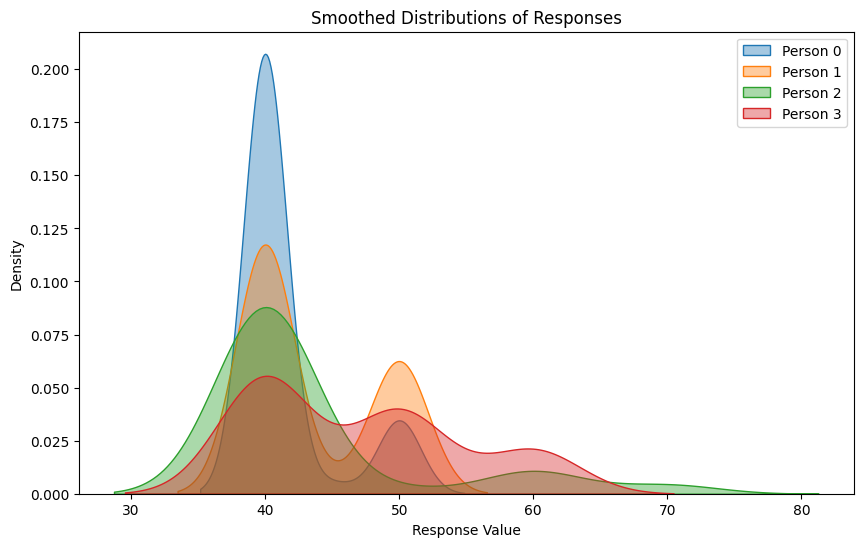

In [9]:
indices = [0, 3, 4, 45]
selected_elements = [people[i] for i in indices]

# 1. Plot Smoothed Distributions (KDE) for Each Person
plt.figure(figsize=(10, 6))
for idx, person in enumerate(selected_elements):
    sns.kdeplot(person["responses"], label=f"Person {idx}", fill=True, alpha=0.4)

plt.xlabel("Response Value")

plt.ylabel("Density")
plt.title("Smoothed Distributions of Responses")
plt.legend()
plt.show()

Make all cross people t-tests of equality of average responses, then plot as simple distribution

In [10]:
from scipy.stats import ttest_ind

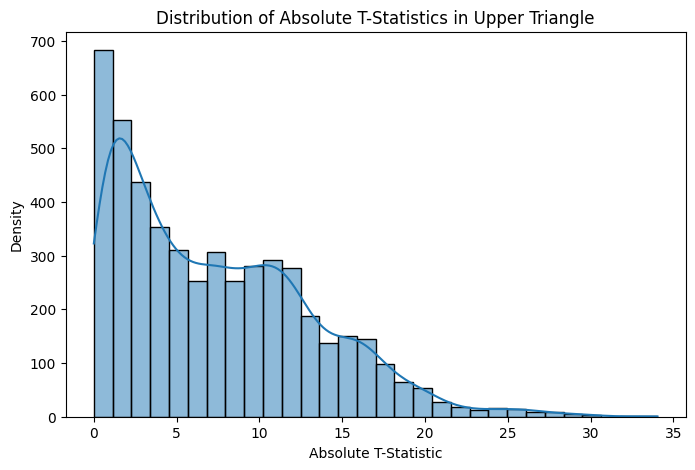

In [11]:
# 2. Compute the T-Test Matrix
num_people = len(people)
t_matrix = np.zeros((num_people, num_people))

for i in range(num_people):
    for j in range(num_people):
        if i != j:
            t_stat, _ = ttest_ind(people[i]["responses"], people[j]["responses"], equal_var=False)
            t_matrix[i, j] = t_stat

# Convert to DataFrame for better visualization
t_matrix_df = pd.DataFrame(t_matrix, columns=[f"P{j}" for j in range(num_people)], index=[f"P{i}" for i in range(num_people)])

size = t_matrix.shape[1]

# Extract the upper triangle without the diagonal
upper_triangle_t_stats = t_matrix[np.triu_indices(size, k=1)] # k=1 excludes the diagonal

# Compute absolute values
abs_upper_triangle_t_stats = np.abs(upper_triangle_t_stats)

# Plot the distribution

plt.figure(figsize=(8, 5))
sns.histplot(abs_upper_triangle_t_stats, bins=30, kde=True)
plt.xlabel("Absolute T-Statistic")
plt.ylabel("Density")
plt.title("Distribution of Absolute T-Statistics in Upper Triangle")
plt.show()

Now do some regressions on some dummies of people's characteristics

In [14]:
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

In [20]:
# 3. Regression Analysis: Responses ~ One-Hot Encoded Attributes
# Extract responses and attributes
responses = []
attributes = []
for person in people:
    responses.extend(person["responses"])
    attributes.extend([person["type"]] * len(person["responses"]))

# Convert attributes to DataFrame
attr_df = pd.DataFrame(attributes)
# make subset of a few attributes - you can play around with these
attr_df_small = attr_df[["myparty", "mysex"]]  

# One-hot encode categorical attributes
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_encoded = encoder.fit_transform(attr_df_small)

# Convert to DataFrame

X_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(attr_df_small.columns))

# Add Intercept for Regression
X_df = sm.add_constant(X_df)

# Convert responses to Series
y = pd.Series(responses)

# Run OLS Regression
model = sm.OLS(y, X_df).fit()

# Display Regression Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     2236.
Date:                Sat, 03 May 2025   Prob (F-statistic):               0.00
Time:                        10:18:45   Log-Likelihood:                -16194.
No. Observations:                5000   AIC:                         3.240e+04
Df Residuals:                    4996   BIC:                         3.242e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      47.7127      0.161    295.609      0.000      47.396      48.029
myparty_Left of Center     -5.5840      0.208    -26.804      0.000      -5.992      -5.176
myparty_Right of Center    12.3711      0.214     57.734      0.000      11.951      12.791
mysex_mother                0.0113      0.175      0.065      0.948      -0.331       0.354
==============================================================================
Omnibus:                      263.143   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              995.484
Skew:                           0.080   Prob(JB):                    6.81e-217
Kurtosis:                       5.180   Cond. No.                         3.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While things like the persons day or major make a small difference, the political leaning makes a economically significant difference